In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter2_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-08-09 12:16:08.464641


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter1")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter1 ckpt_iwvi_pendulum_policy_optimization_iter1
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-4.1484)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(10.3510)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(5.2697)
train_loss:  -5.021236689603328
valid_loss:  -4.706407223892212
h_min_tilde -6.1621075 ell_tilde -4.958270796461105 kappa_tilde 0.000911415091896234
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter1
train_loss:  -3.5933198448181143
valid_loss:  -4.254440541839599
weight_alpha 1.0 h_min_tilde -6.1621075 ell_tilde -3.7255439842224116 kappa_tilde 0.0006406356969815424


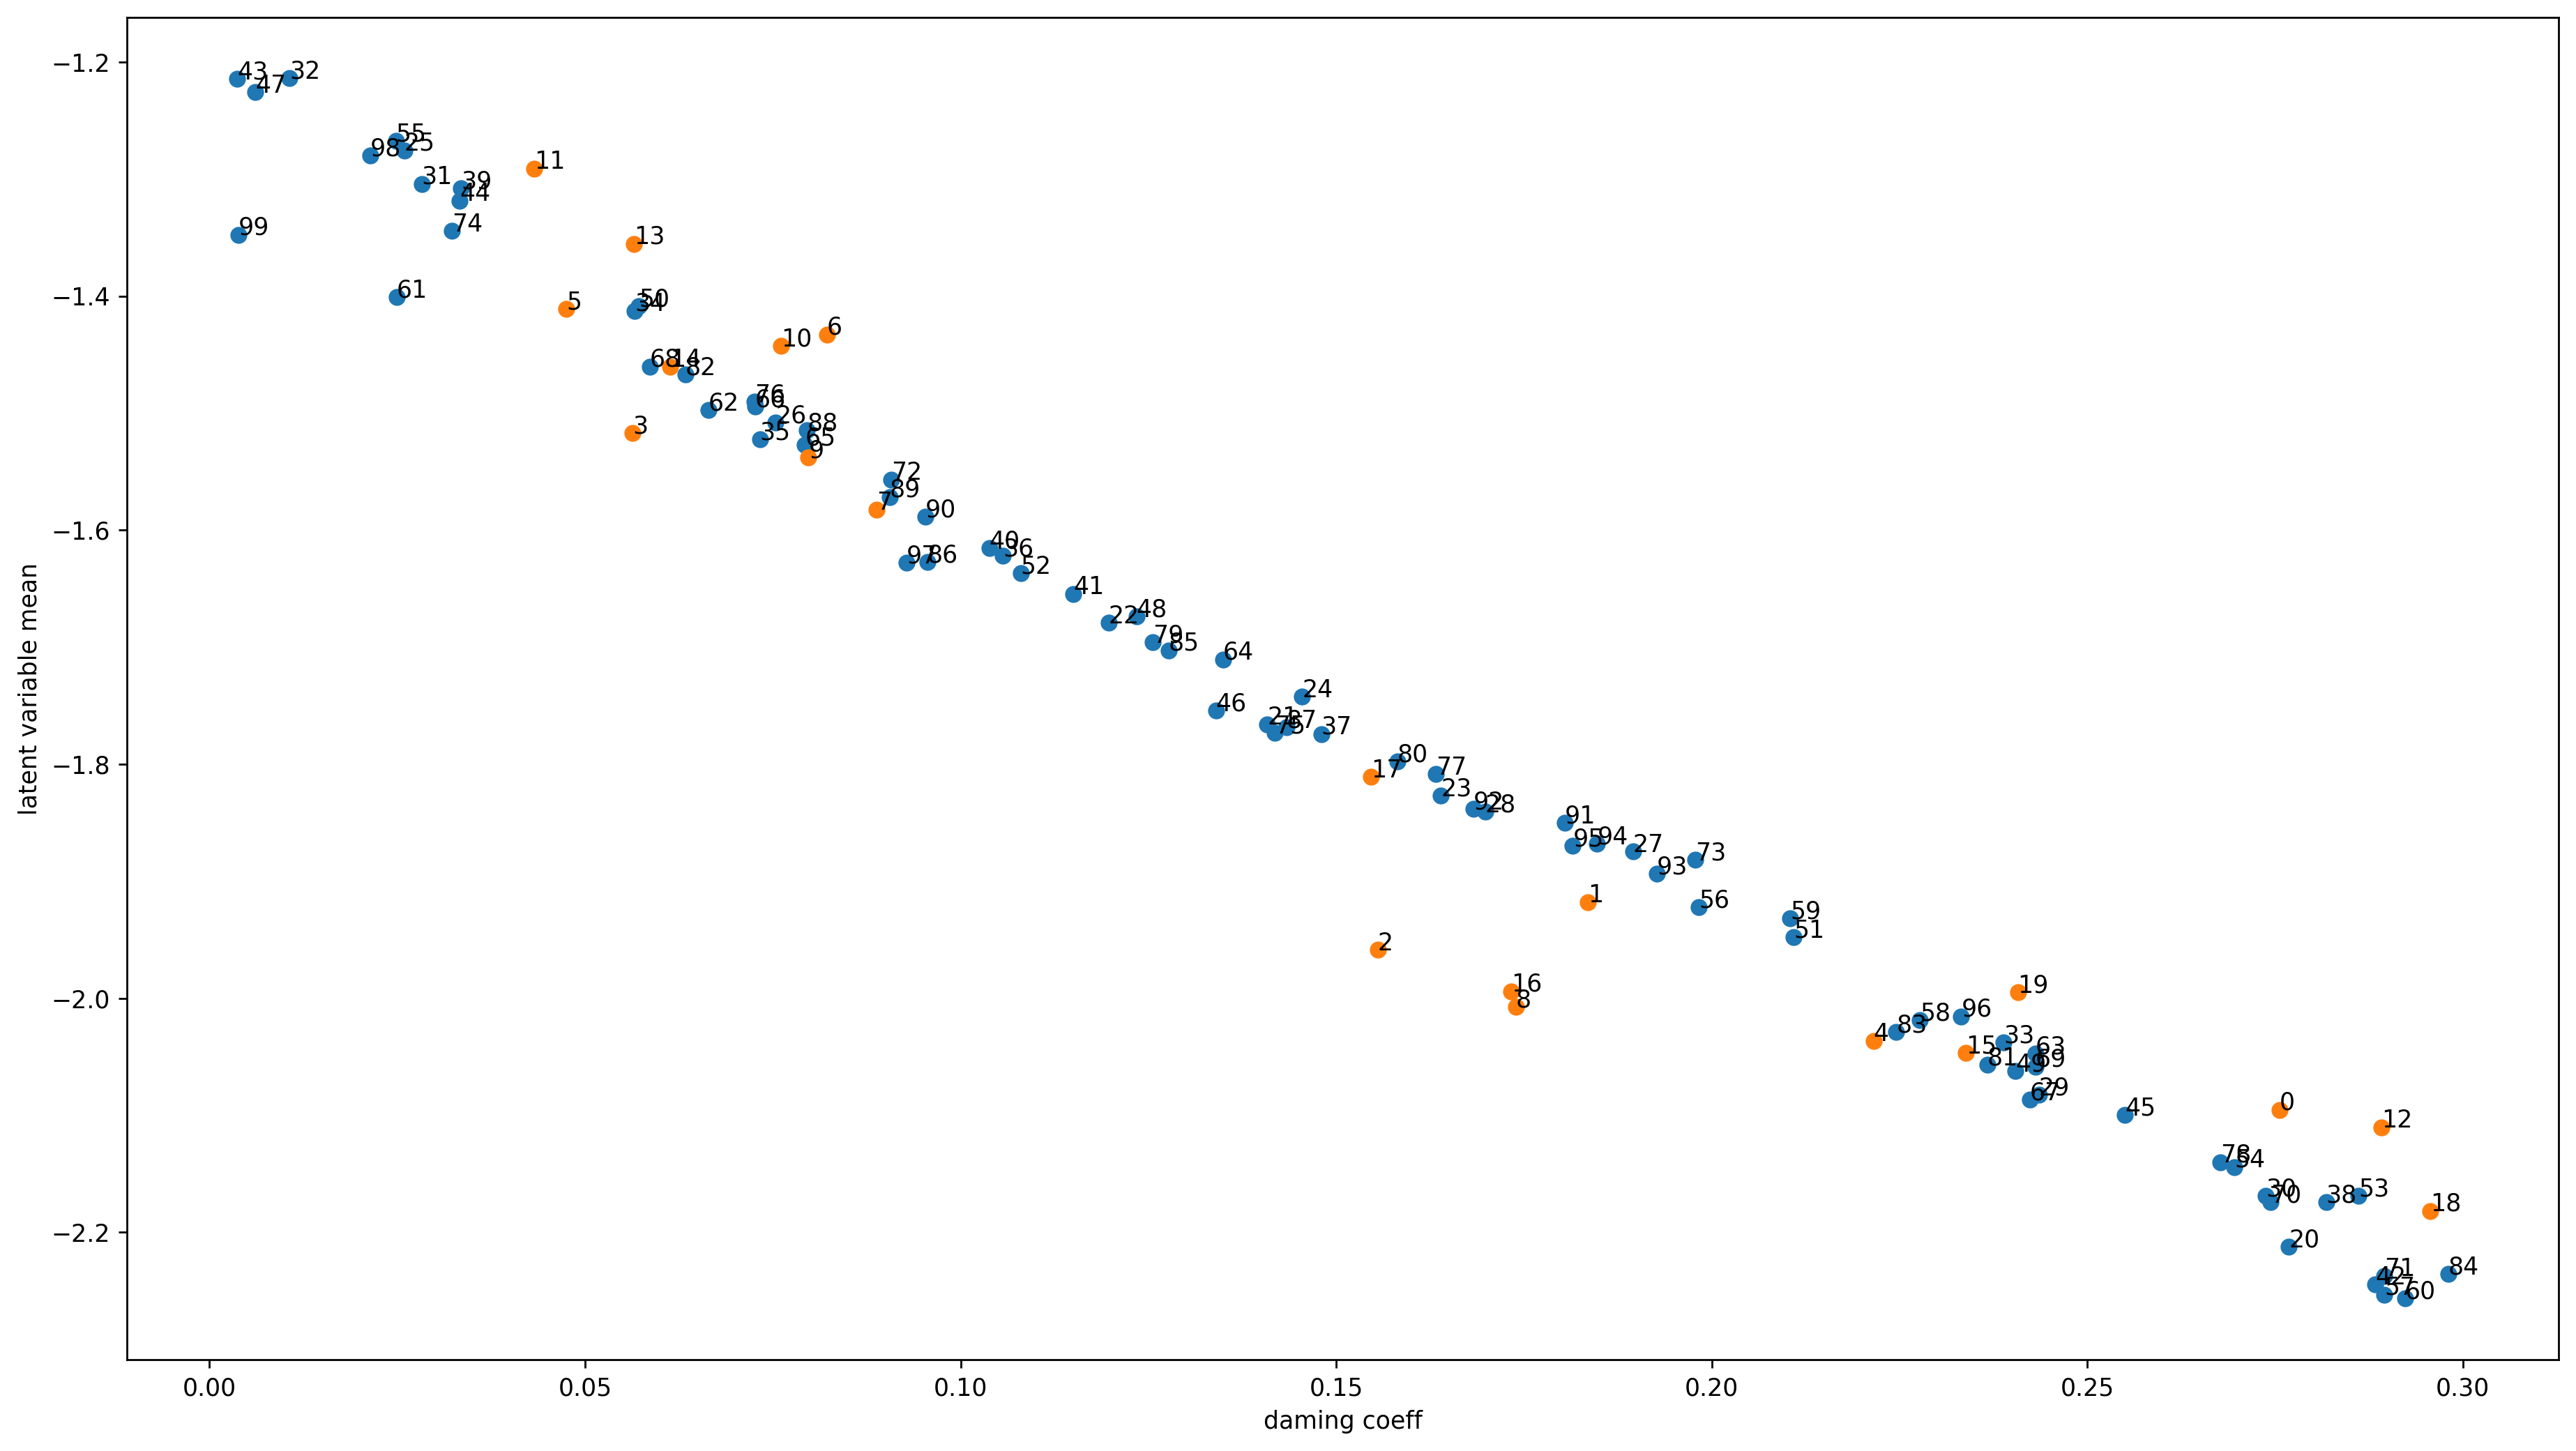

[0.27558327 0.18352316 0.1555254  0.05631637 0.22153209 0.04749296
 0.08222594 0.08882398 0.17395134 0.07974574]
[0.07607646 0.04324929 0.28917916 0.0565244  0.06136666 0.23385438
 0.17329886 0.15464178 0.29568732 0.24074907]
[0.27682488 0.14084651 0.11968344 0.16393695 0.14547932 0.02595771
 0.07537353 0.18952982 0.1698246  0.24357072]
[0.27378803 0.02826082 0.01065271 0.23884282 0.05660032 0.07328726
 0.10562848 0.14802452 0.28178981 0.03350773]
[0.10380845 0.11502272 0.28833092 0.00371082 0.03333322 0.25499401
 0.13398235 0.00611741 0.12341508 0.24042046]
[0.05714333 0.21088262 0.10799496 0.28608915 0.26957135 0.02482157
 0.19825332 0.28954726 0.22772974 0.21046585]
[0.29230484 0.02491633 0.06644483 0.24309427 0.13492307 0.07927151
 0.0726323  0.24233323 0.05860339 0.24308566]
[0.2744203  0.28949899 0.09075543 0.19782518 0.03224686 0.14184845
 0.07255772 0.16326971 0.26769998 0.12559623]
[0.15815365 0.23670303 0.0633423  0.22457274 0.2980512  0.1276912
 0.09559393 0.14338239 0.07956

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 4.699002265930176

 2 7.157545804977417

 3 7.276035785675049

 4 6.668020009994507

 5 6.874770641326904

 6 6.714378356933594

 7 6.485222816467285

 8 4.154815196990967

 9 3.330376625061035

 10 3.3800265789031982

 11 3.0792737007141113

 12 5.475321531295776

 13 3.6450884342193604

 14 3.3759870529174805

 15 3.2538185119628906

 16 3.271596908569336

 17 3.4217519760131836

 18 3.304009199142456

 19 3.2645537853240967

 20 3.3572540283203125

 21 3.364759683609009

 22 4.901110887527466

 23 4.780677795410156

 24 3.532864809036255

 25 3.4356002807617188

 26 3.3735036849975586

 27 3.260333776473999

 28 3.483397960662842

 29 3.3384246826171875

 30 3.037896156311035

 31 3.7694337368011475

 32 3.4514129161834717

 33 5.264730215072632

 34 3.386888027191162

 35 3.5948760509490967

 36 3.5246572494506836

 37 3.403444766998291

 38 4.513030767440796

 39 3.1721577644348145

 40 3.5263466835021973

 41 3.2480013370513916

 42 3.371758222579956

 43 4.242708683013916

 

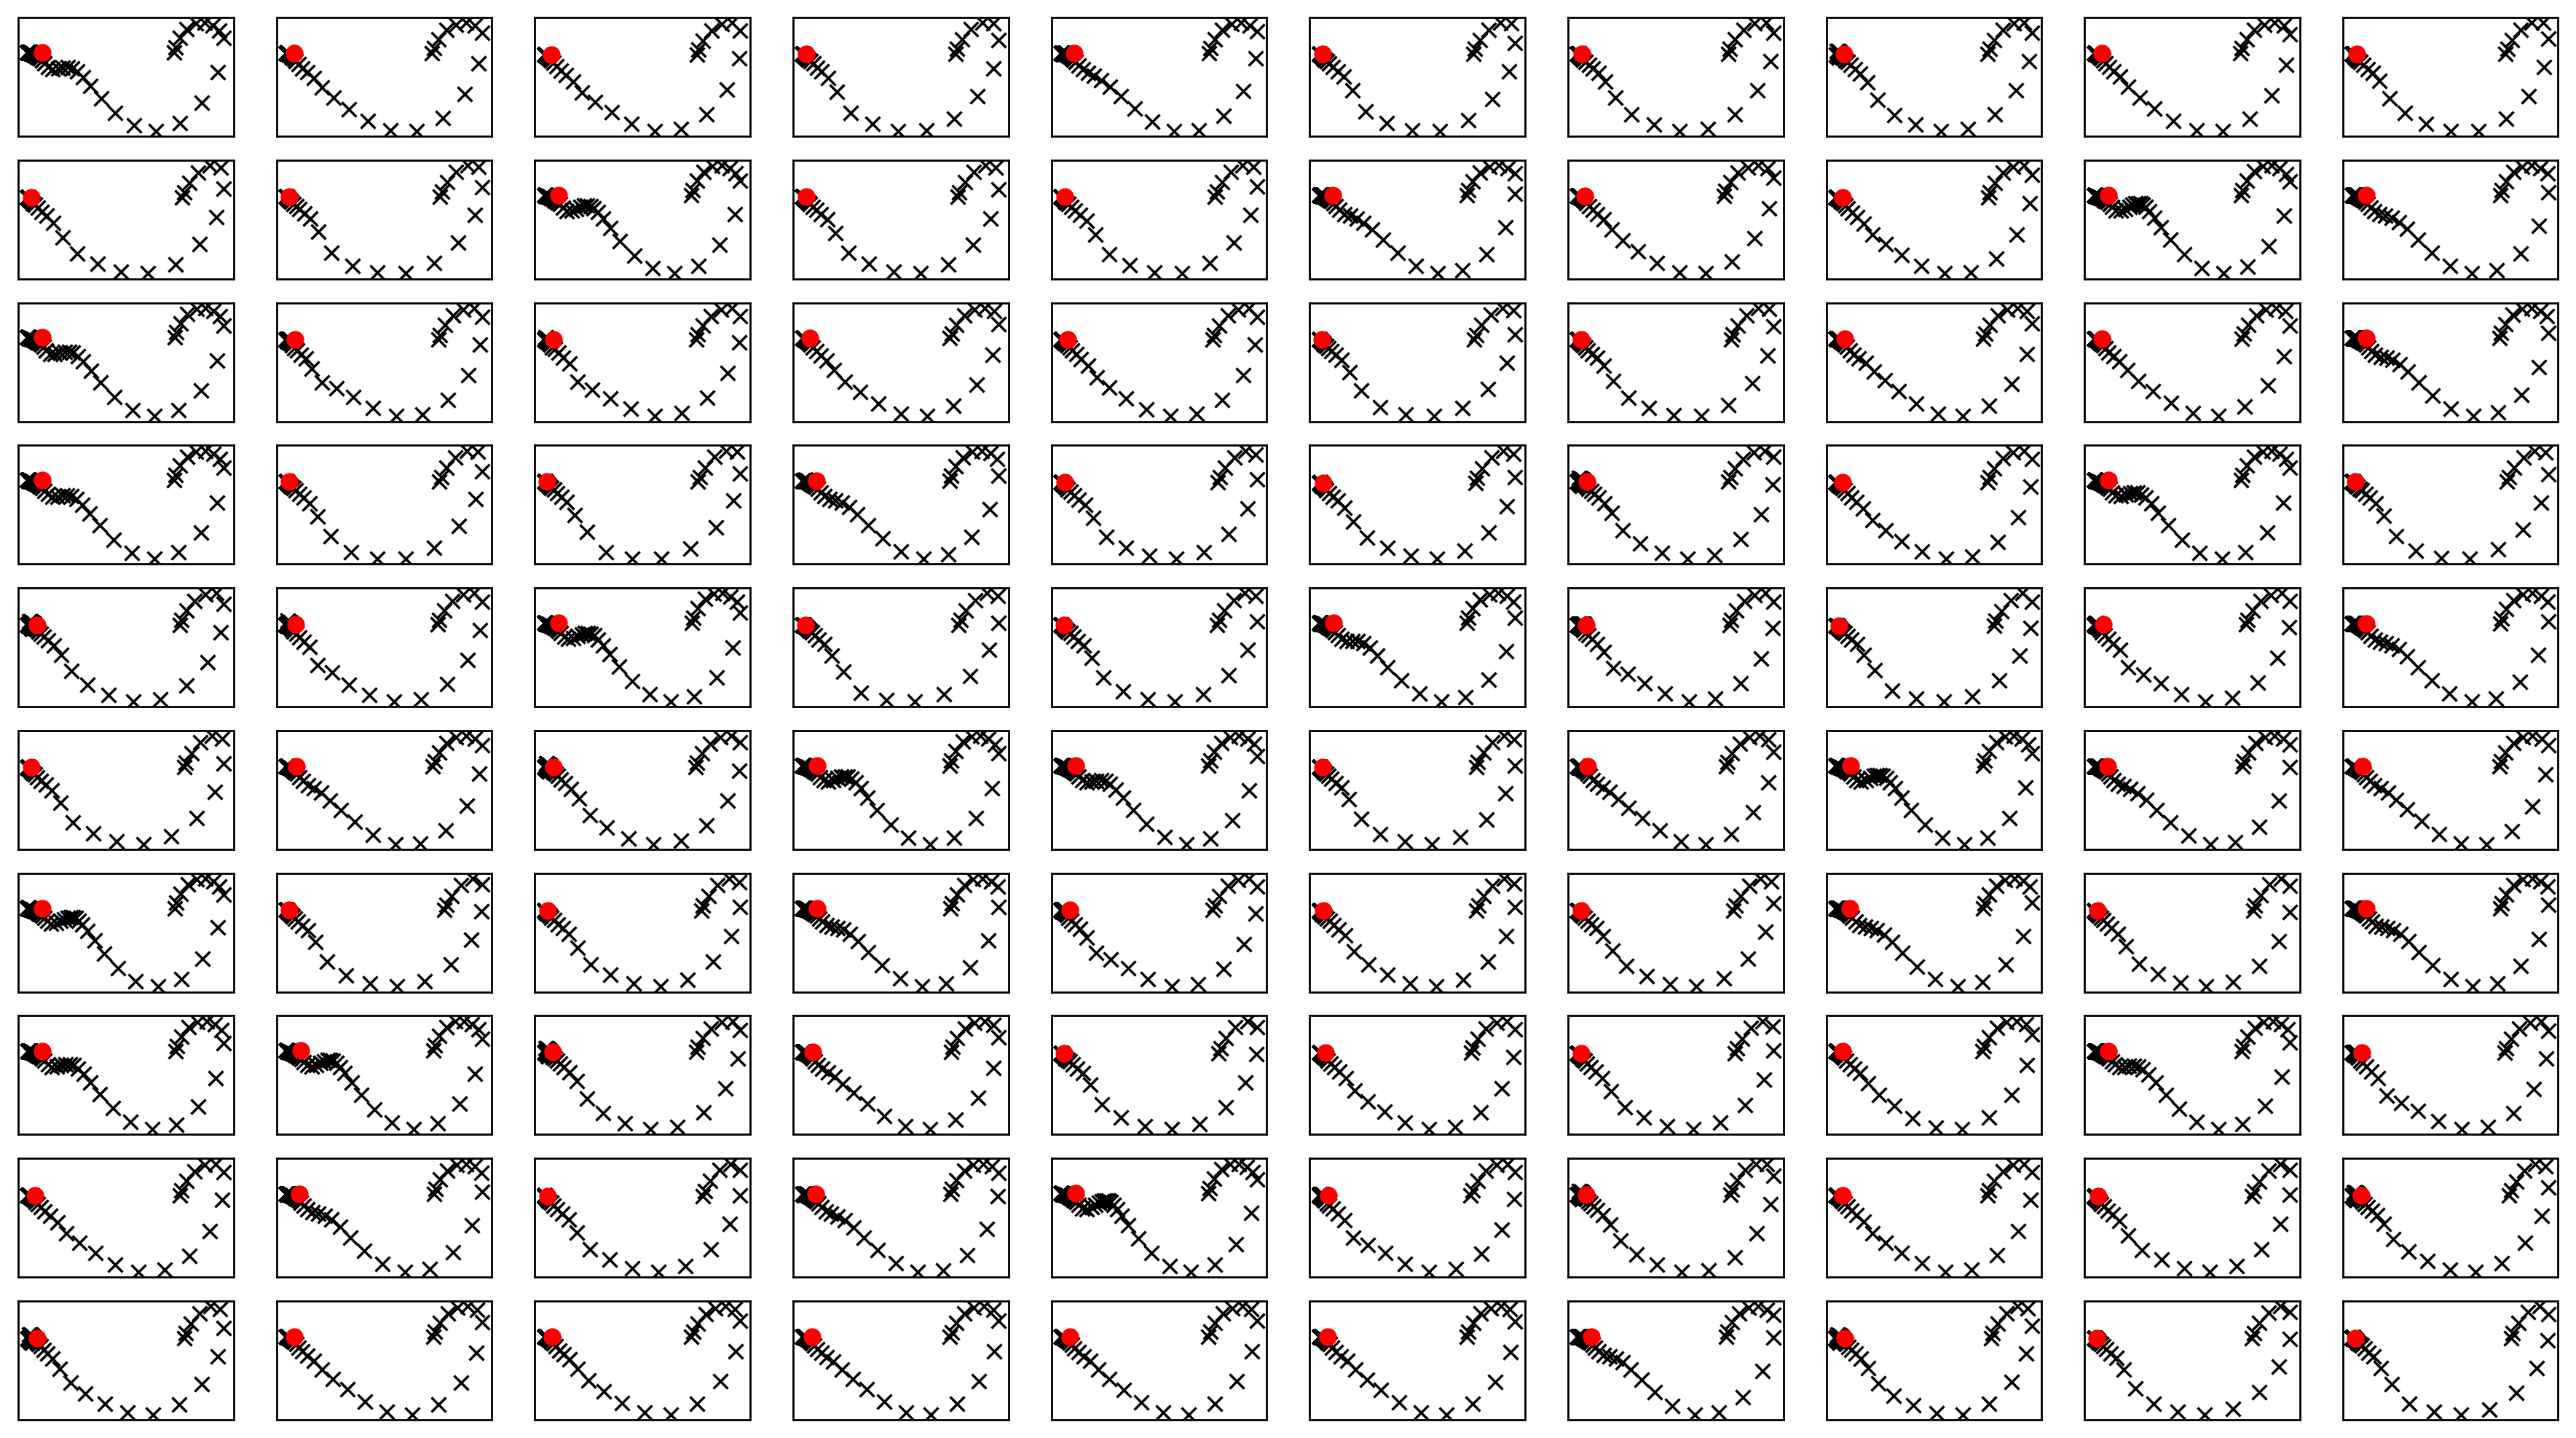

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.402254819869995

 2 3.380772829055786

 3 3.452561140060425

 4 3.5955660343170166

 5 3.306983709335327

 6 3.5803778171539307

 7 3.6525979042053223

 8 3.442617416381836

 9 3.539994478225708

 10 3.4501492977142334

 11 3.383035182952881

 12 3.614349126815796

 13 6.13868260383606

 14 7.493435859680176

 15 7.034071922302246

 16 7.0944578647613525

 17 7.083739757537842

 18 7.37469482421875

 19 5.0151848793029785

 20 3.8099429607391357

 21 3.308936357498169

 22 6.942232131958008

 23 4.901197910308838

 24 3.622067451477051

 25 3.6107728481292725

 26 3.5769734382629395

 27 3.1979167461395264

 28 3.335357189178467

 29 3.649202585220337

 30 3.5047965049743652

 31 3.602720260620117

 32 6.276392936706543

 33 3.466228485107422

 34 3.5852134227752686

 35 3.605401039123535

 36 6.318539381027222

 37 3.4913527965545654

 38 3.480247735977173

 39 3.5007998943328857

 40 4.1198036670684814

 41 3.7906651496887207

 42 5.820225715637207

 43

実環境方策rollout vs Sim環境方策rollout


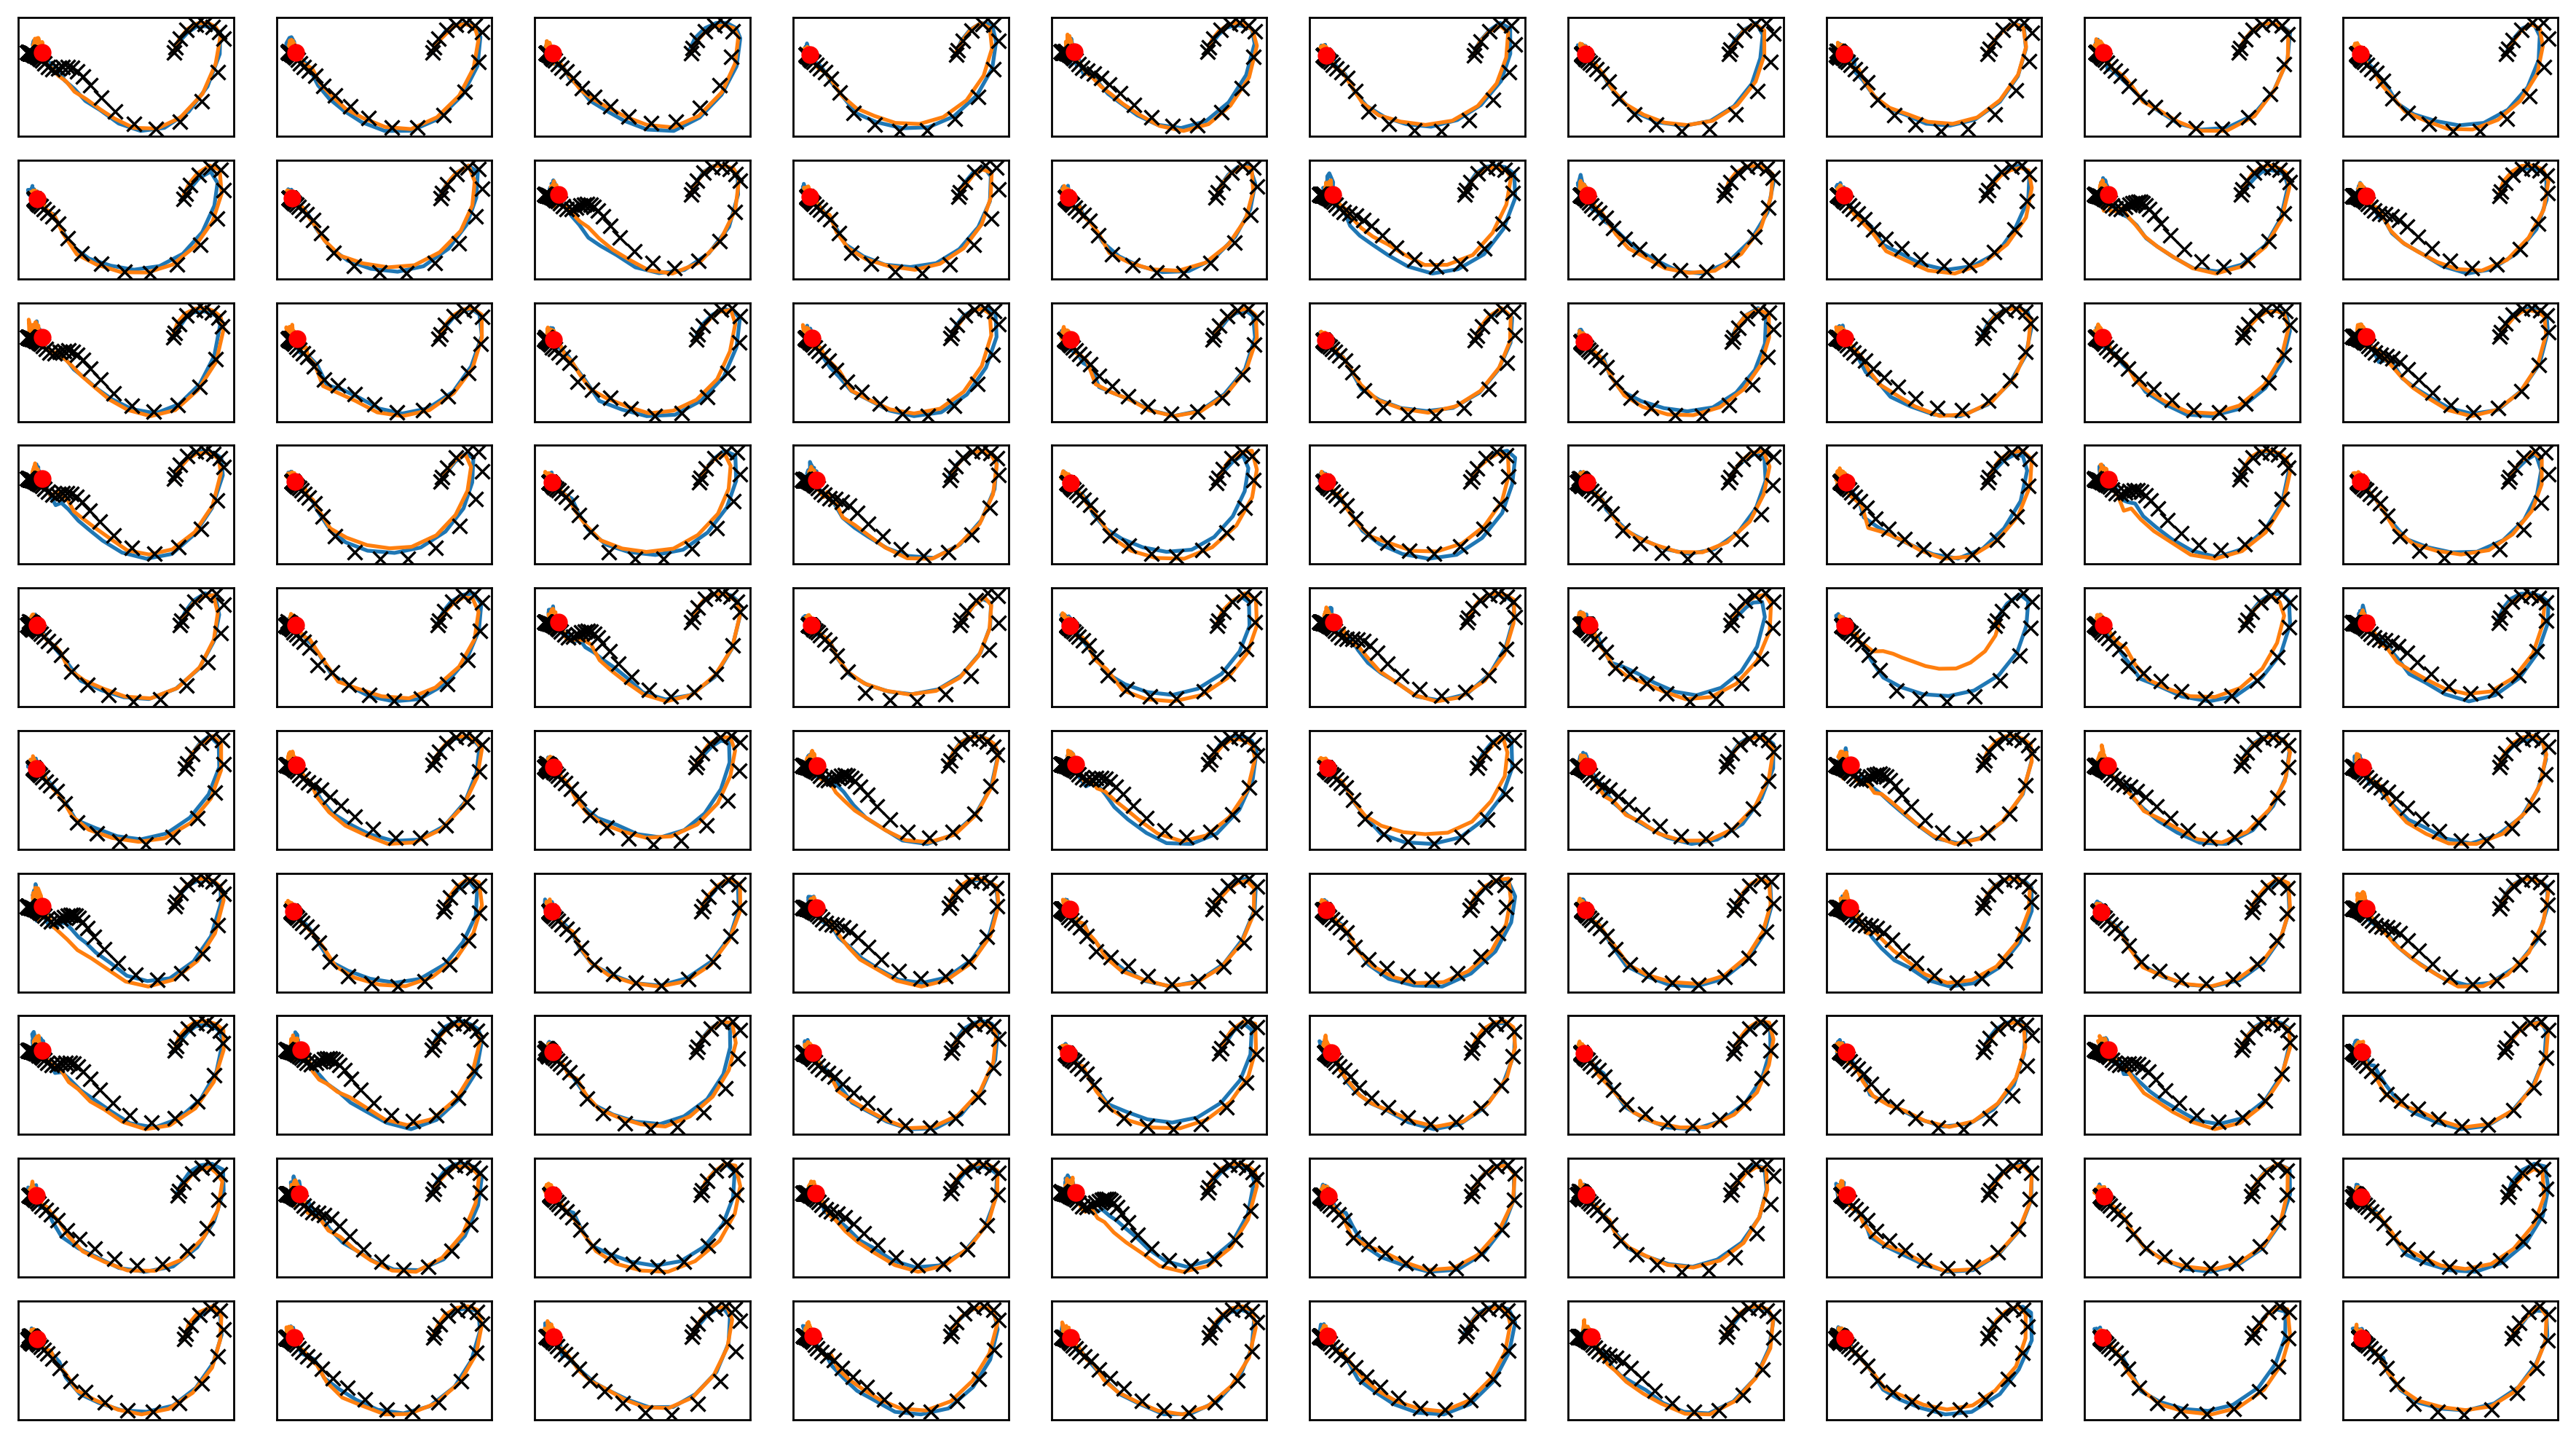

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-08-09 12:39:09.952294
